<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h6><center>Predicting TGV Retards</center></h6>



### Importing libraries

In [28]:
1 # Utilitaries
import os
import numpy as np
import pandas as pd
import resampy
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sn

# Deep learning libraries
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score

### Hyperparameters

In [29]:
SEED = 42

In [30]:
# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

### Getting the data

In [31]:
retards_df = pd.read_csv("data/regularite-mensuelle-tgv-aqst.csv", sep=';')
retards_df.head()


,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,...,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,...,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,...,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,...,8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,...,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


#### Data analysis

In [32]:
retards_df.describe()

,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,commentaire_retards_depart,nb_train_retard_arrivee,retard_moyen_arrivee,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
count,8154.000000,8154.000000,8154.000000,0.0,8154.000000,8154.000000,8154.000000,0.0,8154.000000,8154.000000,...,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000
mean,169.860314,257.198308,11.349644,NaN,88.434265,11.205745,3.076737,NaN,34.516066,33.950971,...,24.434511,32.193823,11.642016,4.245892,23.266846,21.888418,19.052124,18.995179,6.714513,7.127315
std,87.390774,173.815703,26.544553,NaN,90.384803,12.476780,5.432676,NaN,29.729349,15.702663,...,21.400761,20.195926,11.225104,4.901032,16.805192,15.692521,14.947548,14.256533,8.080759,10.249453
min,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,-229.269444,NaN,0.000000,-40.109259,...,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,142.000000,0.000000,NaN,22.000000,5.128410,1.140258,NaN,13.000000,24.636941,...,9.000000,12.140350,4.000000,1.000000,11.764706,11.538462,8.695652,9.523810,0.000000,0.000000
50%,164.000000,221.000000,3.000000,NaN,55.000000,9.036447,2.248271,NaN,27.000000,32.441236,...,19.000000,34.932765,9.000000,3.000000,20.967742,20.000000,16.949153,17.165179,5.000000,3.703704
75%,221.000000,333.000000,10.000000,NaN,129.000000,14.219375,3.903651,NaN,47.000000,41.346717,...,33.000000,44.268749,16.000000,6.000000,32.307692,30.000000,26.923077,26.086957,10.000000,10.000000
max,786.000000,1075.000000,297.000000,NaN,596.000000,316.188095,84.516667,NaN,376.000000,299.600000,...,312.000000,299.600000,202.000000,71.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [33]:
retards_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

##### commentaire retard arrive analyze with NLP ? 

In [34]:
data_to_delete = ["date", "commentaire_annulation", "commentaires_retard_arrivee", "nb_annulation", "commentaire_retards_depart", "nb_train_retard_sup_15","retard_moyen_trains_retard_sup15","nb_train_retard_sup_30", "nb_train_retard_sup_60"]

In [35]:
# Drop the specified columns from the DataFrame
retards_df = retards_df.drop(columns=data_to_delete)
retards_df.head()

,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,289,11.247809,3.693179,147,28.436735,6.511118,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,8,2.875000,0.095796,34,21.524020,5.696096,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,National,PARIS MONTPARNASSE,QUIMPER,220,248,37,9.501351,1.003981,26,55.692308,7.578947,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,National,PARIS MONTPARNASSE,ST MALO,156,102,12,19.912500,1.966667,13,48.623077,6.790686,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,61,7.796995,0.886889,71,12.405164,3.346487,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


In [36]:
retards_df = retards_df.iloc[:, :20]
# Display the resulting DataFrame
retards_df.head()

,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,289,11.247809,3.693179,147,28.436735,6.511118,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,8,2.875000,0.095796,34,21.524020,5.696096,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,National,PARIS MONTPARNASSE,QUIMPER,220,248,37,9.501351,1.003981,26,55.692308,7.578947,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,National,PARIS MONTPARNASSE,ST MALO,156,102,12,19.912500,1.966667,13,48.623077,6.790686,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,61,7.796995,0.886889,71,12.405164,3.346487,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


In [39]:
retards_df['total_retard_mean'] = retards_df['retard_moyen_depart'] + retards_df['retard_moyen_arrivee']
retards_df['total_retard_alltrains_mean'] = retards_df['retard_moyen_tous_trains_depart'] + retards_df['retard_moyen_tous_trains_arrivee']
retards_df.head()

,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,total_retard_mean,total_retard_alltrains_mean
0,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,289,11.247809,3.693179,147,28.436735,6.511118,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336,39.684543,10.204297
1,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,8,2.875000,0.095796,34,21.524020,5.696096,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000,24.399020,5.791892
2,National,PARIS MONTPARNASSE,QUIMPER,220,248,37,9.501351,1.003981,26,55.692308,7.578947,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000,65.193659,8.582928
3,National,PARIS MONTPARNASSE,ST MALO,156,102,12,19.912500,1.966667,13,48.623077,6.790686,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000,68.535577,8.757353
4,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,61,7.796995,0.886889,71,12.405164,3.346487,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000,20.202159,4.233376


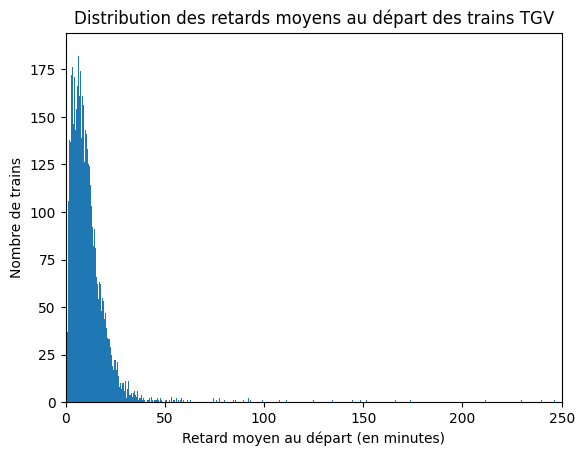

In [40]:
plt.hist(retards_df['retard_moyen_depart'],bins=1000)

# Add labels and title
plt.xlabel('Retard moyen au départ (en minutes)')
plt.xlim([0, 250])
plt.ylabel('Nombre de trains')
plt.title('Distribution des retards moyens au départ des trains TGV')
plt.show()

(-100.0, 100.0)

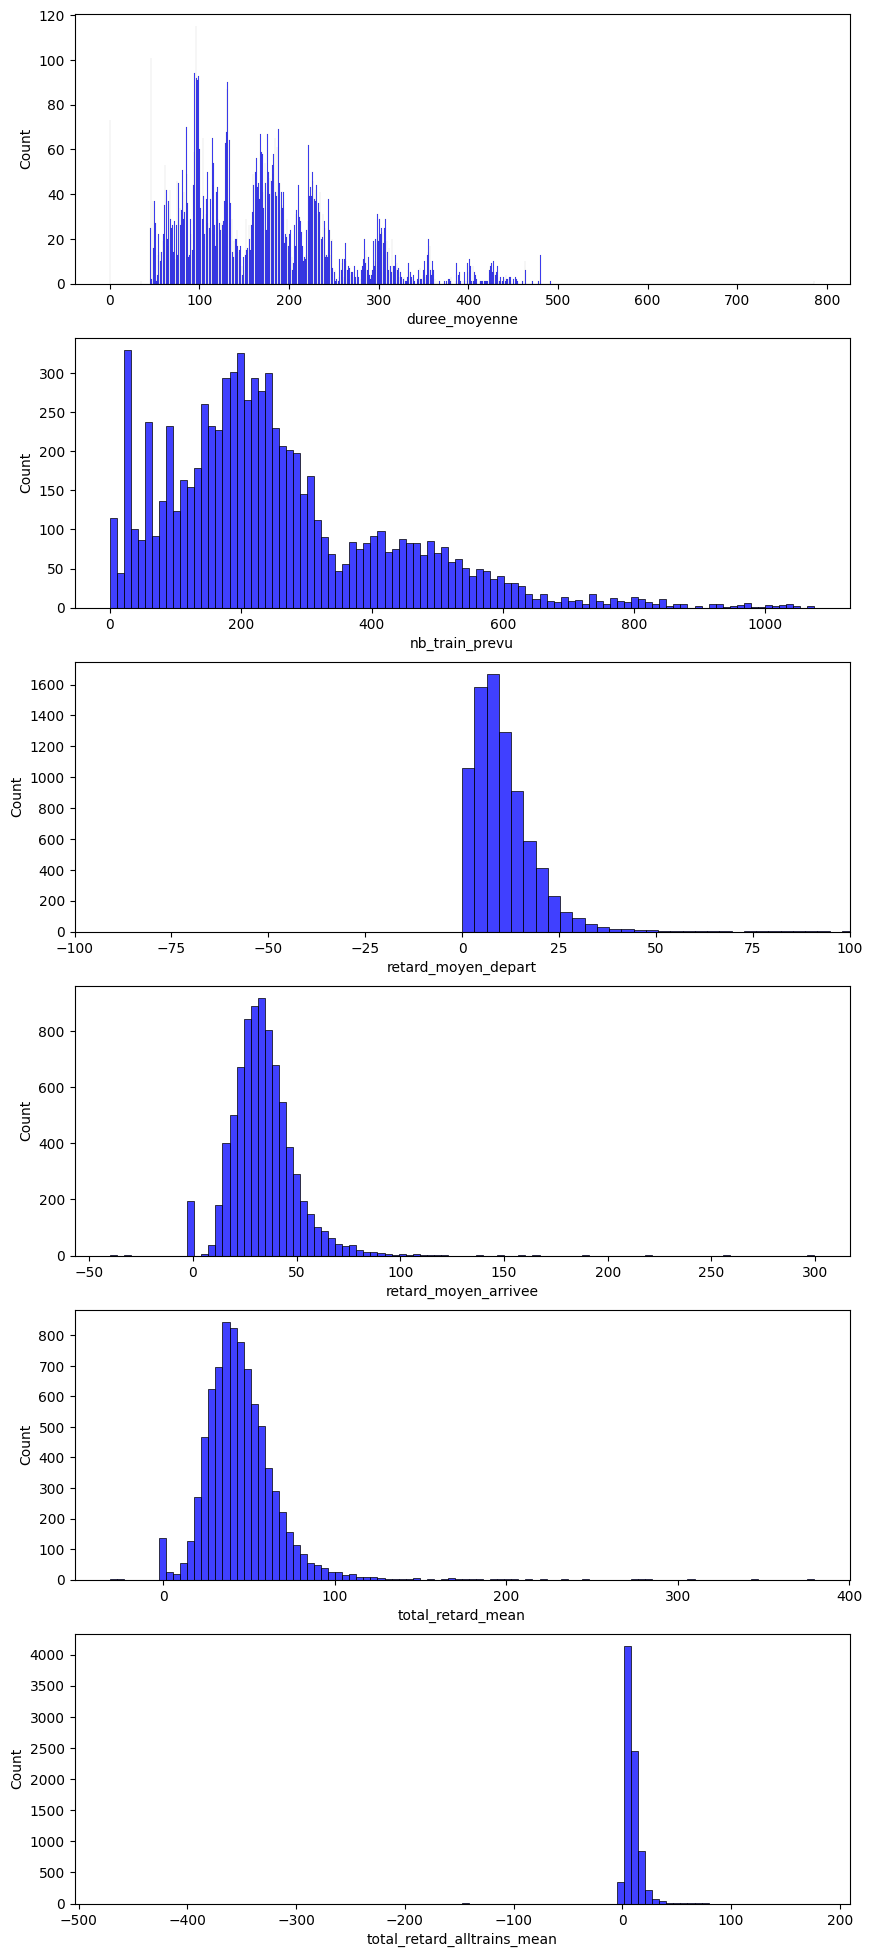

In [44]:
fig, ax = plt.subplots(6,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sn.histplot(retards_df['duree_moyenne'], color='b', bins=1000, ax=ax[0]);
sn.histplot(retards_df['nb_train_prevu'], color='b', bins=100, ax=ax[1]);
sn.histplot(retards_df['retard_moyen_depart'], color='b', bins=100, ax=ax[2]);
sn.histplot(retards_df['retard_moyen_arrivee'], color='b', bins=100, ax=ax[3]);
sn.histplot(retards_df['total_retard_mean'], color='b', bins=100, ax=ax[4]);
sn.histplot(retards_df['total_retard_alltrains_mean'], color='b', bins=100, ax=ax[5]);
ax[2].set_xlim([-100, 100])
